<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2019 Reduction Exercise: Part 2</h2>

In Part 1 you constructed images that were overscan subtracted and trimmed.

In Part 2 you will will:

1. combine your bias frames to make a master bias frame;
2. bias subtract all your images;
3. make a combined flatfield image in each band;
4. flatfield the flatfield images and science images;

Remember that your raw data are stored in ~/RFSLAB/USER_DPT/_PUBLIC/ASTR596/Data/Raw/< your night>
and your reduced images are stored in ~/RFSLAB/USER_DPT/< KUID>/ASTR596/Data/Reduced/< your_night> 

In [1]:
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc
from matplotlib import pyplot as plt
from ccdproc import Combiner
from astropy.io import ascii
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc
from matplotlib import pyplot as plt
from ccdproc import Combiner
from astropy.io import ascii
from astropy.io import fits
import os, glob, time

You will first read in bias images and combine them using the "Combiner" task described at https://ccdproc.readthedocs.io/en/latest/image_combination.html

Make sure to read the section on sigma-clipping, which describes how we generate maskes for comining and eventually combine the images.  

As a first step you will need to make a set of lists that contain files.  You can name the lists what you'd like, e.g. biaslist, but you'll need to make sure that they are in the right places in the program:
1. biaslist: all of your good trimmed bias frames
2. flatlist_< band>: all of the trimmed flatfields corresponding to a given band
3. science_< band>_< target>: all of the science frames for each target in each band

In [2]:
rawpath = "/home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/Raw/"
redpath = "/home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/ReducedData/"
flatpath = "/home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/Flatcorrected/"

biaslist = "biaslist"
biaslistpath = redpath + biaslist

In [2]:



#initialize list of bias frames
bias_imlist = []
#this way of opening the file ensures that it closes after the loop is done.
with open(biaslistpath,'r') as fp:
    #read first line
    line = fp.readline()

    #build the combine list of all images
    #read every subsequent line
    while line:
        #this removes the trailing newline charactter and converts the output list to a scalar
        imname = line.split()
        imname = imname[0]
        
        #create the image name, including the path
        imstr = redpath + imname
        #read that into a CCDData object.  This allows you to specify a unit
        im = CCDData.read(imstr)

        #make a list of all the CCDData instances of each image
        bias_imlist = bias_imlist + [im]

        line = fp.readline()

#Combiner list of all bias images
bias_comb = Combiner(bias_imlist)

#now create masks with sigma clipping algorithm
#This creates a mask for each image that is the size of each image but which has 0 values
#everywhere except those pixels in excess of low_thresh and high_thresh sigma from the median.
#Those pixels get a value of 1
#*************
#given the number of pixels in your image how must you set high_thresh to avoid flagging more than
#about 5 pixels because of expected statistical variations.  Assume the noise is distributed like a Gaussian.
#Remember, you want to get rid of really deviant pixels, so if you set the threshold too high you won't
#get rid of anything!
bias_comb.sigma_clipping(low_thresh=3, high_thresh=5.5, func=np.ma.median)

#Use these masks to combine the images.  This now becomes your master bias
master_bias = bias_comb.average_combine()

#now write out the master bias
masterbiaspath = redpath + 'master_bias.fits'
master_bias.write(masterbiaspath,overwrite=True)


KeyboardInterrupt: 

What follows is a function to subtract bias frame from a list of images

In [3]:
def bias_sub(imlist_name, redpath, master_bias):
    #go through each image in a list, subtract the master bias from that image, and write the image out again.
    #imlist_name: the name of the file (without path) that contains the list of images to subtract the bias from
    #redpath: the path of directory with your reduced data
    #master_bias: the actual CCDData master bias, *not* the filename of the master bias fits file
    masterbias = CCDData.read(redpath+master_bias)
    imlistpath= redpath + imlist_name
    with open(imlistpath,'r') as fp:
        #read first line
        line = fp.readline()

        #read every subsequent line
        while line:
            #read in each file
            imname = line.split()
            imname = imname[0]
            impath = redpath + imname
            #load file into CCDData objet
            im = CCDData.read(impath)
            
            #***********  
            #insert appropriate expression from https://ccdproc.readthedocs.io/en/latest/image_combination.html
            #subtract bias frame
            im_bsub = ccdproc.subtract_bias(im, masterbias)
            #now write out the file, replacing ".fits" with "b.fits"
            bsub_imname = imname.replace('.fits','b.fits',1)
            #print(bsub_imname)
            bsub_path = redpath + bsub_imname
            im_bsub.write(bsub_path,overwrite=True)
            line = fp.readline()



now subtract the bias frames from all images

In [93]:
#**************
#put in the appropriate file name for each of the flats and science frames
#subtract bias from flats in each band (you will need two calls to this function)
#bias_sub("flatlistR", redpath, master_bias)
#bias_sub("flatlistV", redpath, master_bias)
bias_sub("flatlistB", redpath, "master_bias.fits")

#subtract bias from science frames in each band.  You will need to do this for each band and each target
#bias_sub("sciencelist_R_nova",redpath,master_bias)
#bias_sub("sciencelist_V_nova",redpath,master_bias)
#bias_sub("sciencelist_B_nova",redpath,master_bias)
#bias_sub("sciencelist_V_NGC7128",redpath,master_bias)
#bias_sub("sciencelist_B_NGC7128",redpath,master_bias)
print("done")

done


Now combine the flatfields into master flats.  In this process you will scale each object to their mean before combining.  

Here we will use a median combination instead of a sigma clipping combination.  In the cell below please describe why this is a good idea.

<h4>Your answer here:</h4>

Towards the bottom of this routine we will be using a "Lambda" function to normalize our images.  These are small anonymous throw-away functions that are only used once in a code.  Their use is described here https://www.python-course.eu/python3_lambda.php.  

In [14]:
def master_flatmake(imlist_name, redpath, master_flatname):
    #a function that makes a master flatfield, taking its flats from a list.  
    #The process will be very similar to that for bias frames, though we 
    #1) normalize the frames before combining and 
    #2) make it a function as we may need to generate flats for mutliple bands

    #imlist_name: the name of the file (without path) that contains the list of images that will be combined
    #redpath: the path of directory with your reduced data
    #master_flatname: the name of the combined master flatfield

    imlistpath = redpath + imlist_name
    i = 0
   
    #initialize list of flat frames
    flat_imlist = []
    #this way of opening the file ensures that it closes after the loop is done.
    with open(imlistpath,'r') as fp:
        #read first line
        line = fp.readline()
        #build the combine list of all images
        #read every subsequent line
        while line:
            #this removes the trailing newline character and converts the output list to a scalar
            imname = line.split()
            imname = imname[0].replace('.fits','b.fits',1)
           # i += 1
            #print(i)
            #create the image name, including the path
            imstr = redpath + imname
            #read that into a CCDData object.  This allows you to specify a unit
            im = CCDData.read(imstr)
            print('.')
 #           dither = np.asarray(im)
  #          fill = np.full_like(np.ndarray(shape = (15,len(np.asarray(im)[0,:]))), np.ma.median(np.asarray(im)))
   #         print(len(fill))
    #        if i == 2:
     #           dither = np.append(np.asarray(im)[15:,:], fill, axis = 0)
      #      if i == 3:
       #         dither = np.append(fill, np.asarray(im)[:(len(np.asarray(im)[0,:])-15),:], axis = 0)
        #    #make a list of all the CCDData instances of each image
         #   im.data = dither
            #print(len(dither))
            #print(len(im.data))
            flat_imlist = flat_imlist + [im]
            print(line)
            line = fp.readline()
    
    #Combiner list of all flat images
    flat_combiner = Combiner(flat_imlist)
    #######################################
    #this is an anonymous throw away function that takes an argument and is intended
    #to be used just once.  In this case, the scaling functionality of the combiner is 
    #set to scale by the inverse of the mean, so images with high counts get scaled down and
    #images wtih low counts get scaled up
    scaling_func = lambda arr: 1/np.ma.average(arr)
    flat_combiner.scaling = scaling_func
    print(":)")
    #combine the scaled images
    #****************
    #insert appropriate expression from https://ccdproc.readthedocs.io/en/latest/image_combination.html
    master_flat = flat_combiner.median_combine()

    #now write out the master flat
    masterflatpath = redpath + master_flatname
    master_flat.write(masterflatpath,overwrite=True)


Now use this function to generate master flats

In [15]:
#***********
#make the appropriate calles to master_flatmake to make the flatfields. 
#Do this for each of your sets of flatfields
#figure out what the missing argument is
master_flatmake("flatlistB", redpath, 'clippedmaster_flat_B.fits')
#master_flatmake("flatlistV", redpath, 'lacosmic_flat_V.fits')
#master_flatmake("flatlistR", redpath, 'lacosmic_flat_R.fits')
print("done")

.
f001_tr.fits

.
f002_tr.fits

.
f003_tr.fits

.
f004_tr.fits

.
f005_tr.fits

:)
done


Write in the cell below how you can assess whether or not you have a good master flatfield.  What characteristics might you look for and does your master flatfield image have them.  Write also how your master flat differs from the individual flatfield images.

<h4>Your answer goes here:</h4>

-------------------------------
Now we will flatfield all of our science and flatfield images.  This is similar to the process for bias subtraction except that we will be dividing by the master flat, as opposed to subtracting the master bias.

In [21]:
def flat_corr(imlist_name, redpath,flatpath, masterflat_name):
    #go through each image in a list, subtract the master bias from that image, and write the image out again.
    #imlist_name: the name of the file (without path) that contains the list of images to subtract the bias from
    #redpath: the path of directory with your reduced data
    #master_name: the filename of the master flatfield

    masterflat_path = redpath + masterflat_name
    master_flat = CCDData.read(masterflat_path)
    print(".")
    imlistpath= redpath + imlist_name
    with open(imlistpath,'r') as fp:
        #read first line
        line = fp.readline()

        #read every subsequent line
        while line:
            #read in each file
            imname = line.split()
            imname = imname[0].replace(".fits", 'b.fits', 1)
            impath = redpath + imname
            #load file into CCDData objet
            im = CCDData.read(impath)
            
            #***********  
            #insert appropriate expression from https://ccdproc.readthedocs.io/en/latest/image_combination.html
            #subtract bias frame
            im_flat = ccdproc.flat_correct(im, master_flat)
            print(line)
            #now write out the file
            saveimname = imname.replace('.fits','f.fits',1)

            imflat_path = flatpath + saveimname
            im_flat.write(imflat_path,overwrite=True)
            line = fp.readline()



In [22]:
#*************
#flatfield correct all the flats
#put in the correct argument for the function
flat_corr("sciencelist_B_nova", redpath, flatpath, 'clippedmaster_flat_B.fits')
#flat_corr("sciencelist_V_nova", redpath, flatpath, 'clippedmaster_flat_V.fits')
#flat_corr("sciencelist_R_nova", redpath, flatpath, 'clippedmaster_flat_R.fits')
#flatfield correct the science frames in each band
flat_corr("sciencelist_B_NGC7128",redpath, flatpath,'clippedmaster_flat_B.fits')
#flat_corr("sciencelist_V_NGC7128",redpath, flatpath,'clippedmaster_flat_V.fits')
print("done")

.
s056_tr.fits

s057_tr.fits

s058_tr.fits

.
s064_tr.fits

s065_tr.fits

s066_tr.fits

s067_tr.fits

s068_tr.fits

s069_tr.fits

s070_tr.fits

s071_tr.fits

s072_tr.fits

s073_tr.fits

s074_tr.fits

done


**write in this cell how you can tell if your master flatfield in each band did a good job.  Be quantitative if possible.  Also write how the flatfielded science images look different from those before flatfielding.**

A flatfield correction gets rid of circles from dust grains and the uneven detection of light across the ccd surface. So, any of those features remaining in the image likely means that the flatfield correction did not work well. The easiest way to tell is if the center of the image is distinctly brighter (especially in the dark/no object areas).
This is also how they differ, with less washout the details of the image come through clearer and the comparative brightness between objects becomes closer to true.

In [27]:
def combineimage(imlist_name, redpath, flatpath, savename):
    #a function that makes a master flatfield, taking its flats from a list.  
    #The process will be very similar to that for bias frames, though we 
    #1) normalize the frames before combining and 
    #2) make it a function as we may need to generate flats for mutliple bands

    #imlist_name: the name of the file (without path) that contains the list of images that will be combined
    #redpath: the path of directory with your reduced data
    #master_flatname: the name of the combined master flatfield
   # mypath =  "/home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/Flatcorrected/"

    imlistpath = redpath + imlist_name
    imexppath = imlistpath+"ex"
    mypath = "/home/b739c775/Documents/astro596/astr596_obsproject-master2/astr596_obsproject-master/Images/"


    #initialize list of flat frames
    imlist = []
    explist = []
    #this way of opening the file ensures that it closes after the loop is done.
    with open(imlistpath,'r') as fp:
        #read first line
        line = fp.readline()

        #build the combine list of all images
        #read every subsequent line
        while line:
            #this removes the trailing newline charactter and converts the output list to a scalar
            imname = line.split()
            imname = imname[0].replace('.fits','bfy.fits',1)
        
            #create the image name, including the path
            imstr = flatpath + imname
            #read that into a CCDData object.  This allows you to specify a unit
            im = CCDData.read(imstr)
            #make a list of all the CCDData instances of each image
            saveimlist = imlist + [im]

            line = fp.readline()
    with open(imexppath,'r') as ff:
        #read first line
        line = ff.readline()

        #build the combine list of all images
        #read every subsequent line
        while line:
            #this removes the trailing newline charactter and converts the output list to a scalar
            exp = line.split()
            print(exp[0])
            #make a list of all the CCDData instances of each image
            explist = explist + [float(exp[0])]
            line = ff.readline()

    #Combiner list of all flat images
    explist = (np.ones_like(explist)/explist)
    print(explist)
    im_combiner = Combiner(saveimlist)
    im_combiner.scaling = explist
    #######################################
    #this is an anonymous throw away function that takes an argument and is intended
    #to be used just once.  In this case, the scaling functionality of the combiner is 
    #set to scale by the inverse of the mean, so images with high counts get scaled down and
    #images wtih low counts get scaled up
    hdr = fits.getdata(imname, header=True) 
    #combine the scaled images
    #****************
    #insert appropriate expression from https://ccdproc.readthedocs.io/en/latest/image_combination.html
    image = im_combiner.median_combine()
    cleanimage = ccdproc.cosmicray_lacosmic(image, sigclip=4)
    hdr['EXP_TIME'] = 1.0
    #this takes the header of the last file in the list writes it as the header of the combined file.
    combined_img.meta = hdr
    #now write out the master flat
    masterflatpath = flatpath + savename
    cleanimage.write(masterflatpath,overwrite=True)

In [29]:
combineimage("sciencelist_R_nova",redpath, flatpath, "NovaR.fits")
combineimage("sciencelist_V_nova",redpath, flatpath, "NovaV.fits")
combineimage("sciencelist_B_nova",redpath, flatpath, "NovaB.fits")
combineimage("sciencelist_V_NGC7128",redpath, flatpath, "NGC7128V.fits")
combineimage("sciencelist_B_NGC7128",redpath, flatpath, "NGC7128B.fits")

print("done")

FileNotFoundError: [Errno 2] No such file or directory: '/home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/Flatcorrected/s052_trbfy.fits'

In [ ]:
def badcol(k):
    badcols = {1630, 1632, 631}
    badcols.update(set(range(760,1000)))
    if k not in badcols:
        return True
    else:
        return False
def badrow(w):
    badrows = {513,514,1026,1027,1538}
    badrows.update(set(range(1000,1200)))
    if w not in badrows:
        return True
    else:
        return False

In [81]:
def starkiller(imname, redpath, savename):
    imstr = redpath + imname 
    goodcol = list(filter(badcol, np.arange(2048))) #create array of indecies which are not bad pixels
    goodrow = list(filter(badrow, range(2048))) #same as above
    im = CCDData.read(imstr) #read in data
    im = ccdproc.cosmicray_lacosmic(im, sigclip=4) #remove cosmic rays just to be thorough
    for i in list(filter(badrow, range(200, len(im.data)-200))): #loop through each row in the image
            if (np.max(im.data[i,goodcol])) > 1.055:  #if the maximum value in the row is larger than some threshhold
                #print(".", end = '')
                centerrow=i  #then look for the column which corresponds to the maximum of row i
                print(np.amax(im.data[i,goodcol]))
                r = 12      #radius of correction, must be bigger than star
                #if (im.data[i,y]) == np.amax(im.data[i,goodrow]) and y != 1630 and y != 1632 and y != 631:
                centercolumn= list(im.data[i,:]).index(np.max(np.array(im.data[i,goodcol]))) #return the index of the column which matches the max of row i
                mij = centercolumn-r #create some parameters for use in the correction
                maj = centercolumn+r
                mirow = centerrow-r
                marow = centerrow +r
                diff = maj-mij
                diff2 = 20
                print(i,centercolumn)
                im.data[mirow:marow, mij:maj] = (im.data[mirow:marow, (mij-diff2):(maj-diff2)]+im.data[mirow:marow,(mij+diff2):(maj+diff2)]+im.data[(mirow-diff2):(marow-diff2),mij:maj]+im.data[(mirow+diff2):(marow+diff2), mij:maj])/4
                #this line consists of taking each pixel in the area to be corrected, 
                #taking the average of the four pixels distance r away in all four directions, 
                #and returning value to the original pixel, thus removing the star
                #Everything after plots the center row's values to check that the star's influence is gone
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    axes[0].set_ylim(bottom = np.median(im.data[centerrow,:]), top = np.median(im.data[centerrow,:]))
    axes[0].hist(im[centerrow,:], bins = 100)
    axes[1].scatter(range(len(np.asarray(im[centerrow,:]))), im[centerrow,:].data, marker = '.')
    axes[1].set_ylim(bottom = np.median(im.data[centerrow,:]-.05), top = np.median(im.data[centerrow,:]+.05))
    axes[1].set_xlim(left = centercolumn - 50, right = centercolumn +50)
    plt.show()
    im.write(redpath+savename, overwrite = True)

1.0552785
1300 1202
1.0559862
1301 730
1.0561953
1355 1288
1.0569333
1357 1140
1.0576953
1358 1042
1.0565716
1373 756
1.0899906
1405 437
1.059855
1539 546


/home/b739c775/.conda/envs/python3env/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempting to set identical bottom == top == 1.0242164134979248 results in singular transformations; automatically expanding.


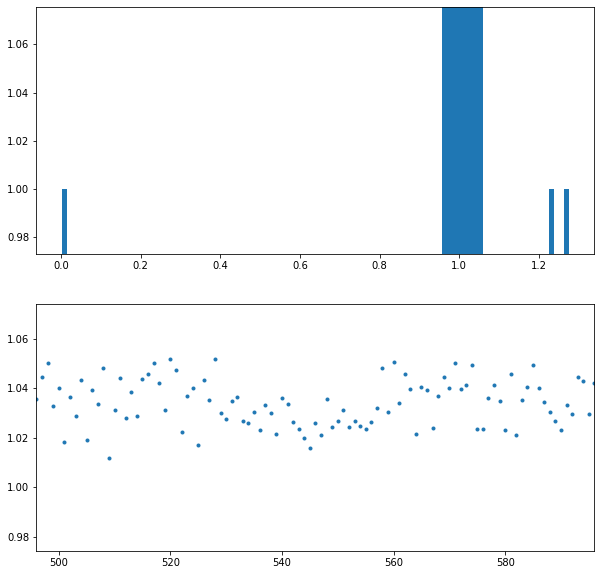

In [82]:
starkiller("clippedmaster_flat_B.fits", redpath, "Bflat.fits")